# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [8]:
!unzip train.zip
!ls

Archive:  train.zip
   creating: train_articles/
  inflating: train.json              
  inflating: train_articles/55701.txt  
  inflating: train_articles/134107.txt  
  inflating: train_articles/45107.txt  
  inflating: train_articles/89894.txt  
  inflating: train_articles/123173.txt  
  inflating: train_articles/86133.txt  
  inflating: train_articles/9062.txt  
  inflating: train_articles/91887.txt  
  inflating: train_articles/93338.txt  
  inflating: train_articles/60364.txt  
  inflating: train_articles/58197.txt  
  inflating: train_articles/152215.txt  
  inflating: train_articles/111602.txt  
  inflating: train_articles/97543.txt  
  inflating: train_articles/101058.txt  
  inflating: train_articles/57647.txt  
  inflating: train_articles/63102.txt  
  inflating: train_articles/58351.txt  
  inflating: train_articles/111310.txt  
  inflating: train_articles/77728.txt  
  inflating: train_articles/14417.txt  
  inflating: train_articles/110546.txt  
  inflating: train_articles

In [0]:
import json
import numpy as np


# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

metadata;

# RNN architecture

We define a simple RNN that processes one token at time to update a hidden vector.  The last hidden vector is passed to a classifier that uses a softmax to predict the category.

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
      
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

# Sample a claim & claimant
Sample a claim, tokenize it and embed it.

In [11]:
!pip install bpemb
from bpemb import BPEmb
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id



     |████████████████████████████████| 1.0MB 7.7MB/s 
downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 577985.00B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1924908/1924908 [00:01<00:00, 1729422.02B/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def sampleClaimant(id): 
    claimant = metadata[id]["claimant"]
    embedding = bpemb_en.embed(claimant)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    claimant_tensor = torch.tensor(embedding, dtype=torch.float)
    return claimant_tensor, claimant

# Training procedure


In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# Train RNN and plot results





Train: 1000  1% (0m 11s) average_accuracy=0.5340 average_loss=0.9709 "Public trust in our election system is at an all-time low." / 1 ✗ (0)
Test: 1000  1% (0m 11s) average_accuracy=0.5220 average_loss=0.9588 "Mr. Trump is self-financing his campaign, so we don’t have any donors." / 1 ✗ (0)
Train: 2000  2% (0m 23s) average_accuracy=0.5710 average_loss=0.9433 "Wisconsin does not have a deficit. Thanks to Republican reforms, the 2014 budget will begin with a $443 million surplus." / 1 ✓
Test: 2000  2% (0m 23s) average_accuracy=0.5170 average_loss=0.9435 "John McCain intervened, which helped Airbus get that Pentagon contract." / 1 ✓
Train: 3000  3% (0m 35s) average_accuracy=0.5590 average_loss=0.9073 Outback Steakhouse announced that supporters of President Donald Trump are barred from their restaurants. / 0 ✓
Test: 3000  3% (0m 35s) average_accuracy=0.5570 average_loss=0.9404 "Black Diamond Collection" Disney films on VHS are worth thousands of dollars, particularly "Beauty and the Beast.

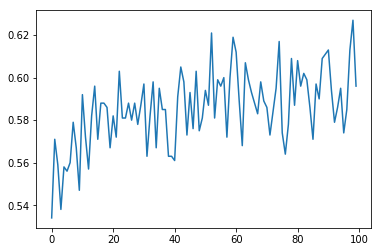

In [23]:
import time
import math

n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_accuracies)

In [0]:
#Saving data
import json
with open('A5Q2A_all_train_accuracies.json', 'w') as f:
    json.dump(all_train_accuracies, f)
    
with open('A5Q2A_all_test_accuracies.json', 'w') as f:
    json.dump(all_test_accuracies, f)

In [0]:
#Loading Data
import json
with open('A5Q2A_all_train_accuracies.json', 'r') as f:
   all_train_accuracies = json.load(f)
    
with open('A5Q2A_all_test_accuracies.json', 'r') as f:
   all_test_accuracies = json.load(f)

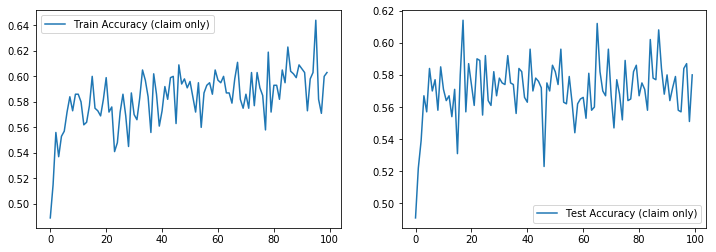

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(all_train_accuracies, label = 'Train Accuracy (claim only)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(all_test_accuracies, label = 'Test Accuracy (claim only)')
plt.legend()

# Preprocess articles

This code preprocesses the aticles to extract the top 5 sentences with greatest similarity to the claim according to tf-idf.

In [16]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A

# Q2a) ii
# Claim & Claimant as Input to Neural Network 

In [0]:
def train_ii(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn_ii.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn_ii(line_tensor[i], hidden)
    output = classifier_ii(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

Train: 1000  1% (0m 8s) average_accuracy=0.5080 average_loss=0.9717 Sylvester Stallone has passed away from prostate cancer. / 0 ✓
Test: 1000  1% (0m 8s) average_accuracy=0.4260 average_loss=0.9954 "Half of all CEOs say that the shutdown and the threat of shutdown set back their plans to hire over the next six months." / 0 ✗ (1)
Train: 2000  2% (0m 17s) average_accuracy=0.5810 average_loss=0.9314 A half dozen Trump-related entities were under criminal investigation in December 2018. / 0 ✗ (1)
Test: 2000  2% (0m 17s) average_accuracy=0.4490 average_loss=1.0101 Images of a suspect arrested over the killing of a Philippine teenager / 0 ✓
Train: 3000  3% (0m 25s) average_accuracy=0.6060 average_loss=0.8901 A man was released from jail in Texas after outliving his 99-year prison sentence for horse theft. / 0 ✓
Test: 3000  3% (0m 25s) average_accuracy=0.4580 average_loss=1.0303 "I got a very, very small loan from my father many years ago. I built that into a massive empire." / 0 ✓
Train: 400

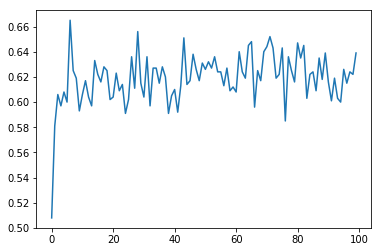

In [22]:
import time
import math

n_hidden = 128
n_categories = 3
rnn_ii = RNN(n_embedding_dims, n_hidden) #multiplied by 2 for claim+claimant
classifier_ii = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn_ii.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier_ii.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses = []
all_train_accuracies_ii = []
all_test_losses = []
all_test_accuracies_ii = []
count = 0
for iter in range(1, n_iters + 1):
    train_claim_tensor, train_category_tensor, train_claim, train_category, train_id = sampleClaim(train_data)
    train_claimant_tensor, train_claimant = sampleClaimant(train_id)
    
    train_line_tensor = torch.cat((train_claim_tensor, train_claimant_tensor), 0)
    
     
    train_output, train_loss = train_ii(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_claim_tensor, test_category_tensor, test_claim, test_category, test_id = sampleClaim(test_data)
    test_claimant_tensor, test_claimant = sampleClaimant(test_id)
    test_line_tensor = torch.cat((test_claim_tensor, test_claimant_tensor), 0)
    
    test_output, test_loss = train_ii(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_claim, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_claim, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies_ii.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies_ii.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_accuracies_ii)

In [0]:
#Saving data
import json
with open('A5Q2A_all_train_accuracies_ii.json', 'w') as f:
    json.dump(all_train_accuracies_ii, f)
    
with open('A5Q2A_all_test_accuracies_ii.json', 'w') as f:
    json.dump(all_test_accuracies_ii, f)

In [0]:
#Loading Data
import json
with open('A5Q2A_all_train_accuracies_ii.json', 'r') as f:
   all_train_accuracies_ii = json.load(f)
    
with open('A5Q2A_all_test_accuracies_ii.json', 'r') as f:
   all_test_accuracies_ii = json.load(f)

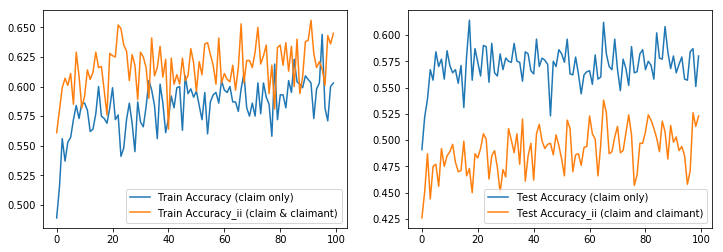

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(all_train_accuracies, label = 'Train Accuracy (claim only)')
plt.plot(all_train_accuracies_ii, label = 'Train Accuracy_ii (claim & claimant)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(all_test_accuracies, label = 'Test Accuracy (claim only)')
plt.plot(all_test_accuracies_ii, label = 'Test Accuracy_ii (claim and claimant)')
plt.legend()

# Q2a) iii
## Claim, claimant, and sample sentences as inputs to RNN

In [0]:
def sampleSentences(id): 
  
  sentences = relevant_sentences[0]
  sentences_tensor = torch.tensor([])
  for i in range(5):
    embedding = bpemb_en.embed(relevant_sentences[0][i])
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    sentence_tensor = torch.tensor(embedding, dtype=torch.float)
    sentences_tensor = torch.cat((sentences_tensor, sentence_tensor), 0)
  
  return sentences_tensor, sentences

In [0]:
def train_iii(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn_iii.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn_iii(line_tensor[i], hidden)
    output = classifier_iii(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

Train: 1000  1% (0m 53s) average_accuracy=0.4760 average_loss=0.9568 "Roy Cooper's refusal to do his job is costing taxpayers money." / 0 ✗ (1)
Test: 1000  1% (0m 53s) average_accuracy=0.4420 average_loss=0.9713 Scientific studies support the conclusion that marijuana can play a role in healing broken bones. / 0 ✗ (1)
Train: 2000  2% (1m 46s) average_accuracy=0.4690 average_loss=0.9540 It’s "typical" for a presidential candidate to release 10 or 11 years of tax returns. / 0 ✗ (1)
Test: 2000  2% (1m 46s) average_accuracy=0.4730 average_loss=0.9472 Donald Trump said there should be "some form of punishment" for women who have abortions.

				
					

						See Example(s)

						
							
								
									
SHOCKING SHOCKER: Trump Takes Left-wing Parody of Conservative Position on Abortion
— Trumpbart News (@Trumpbart) March 30, 2016


Wondering if this is true:

Trump says if he's elected there will be "some form of punishment" for abortion. As if Trump being president wouldn't be enough p

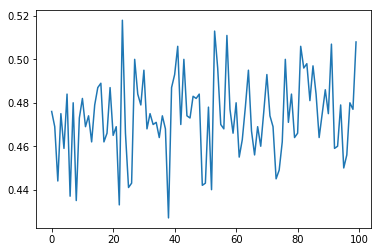

In [0]:
import time
import math

n_hidden = 128
n_categories = 3
rnn_iii = RNN(n_embedding_dims, n_hidden) #multiplied by 2 for claim+claimant
classifier_iii = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn_iii.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier_iii.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses = []
all_train_accuracies_iii = []
all_test_losses = []
all_test_accuracies_iii = []
count = 0
for iter in range(1, n_iters + 1):
    train_claim_tensor, train_category_tensor, train_claim, train_category, train_id = sampleClaim(train_data)
    train_claimant_tensor, train_claimant = sampleClaimant(train_id)
    
    train_sentences_tensor, train_sentences = sampleSentences(train_id)
    
    train_line_tensor = torch.cat((train_claim_tensor, train_claimant_tensor, train_sentences_tensor), 0)
    
     
    train_output, train_loss = train_iii(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_claim_tensor, test_category_tensor, test_claim, test_category, test_id = sampleClaim(test_data)
    test_claimant_tensor, test_claimant = sampleClaimant(test_id)
    test_sentences_tensor, test_sentences = sampleSentences(test_id)
    test_line_tensor = torch.cat((test_claim_tensor, test_claimant_tensor, test_sentences_tensor), 0)
        
    test_output, test_loss = train_iii(test_category_tensor, test_line_tensor, update=False)
    
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_claim, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_claim, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies_iii.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies_iii.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_accuracies_iii)

In [0]:
#Saving data
import json
with open('A5Q2A_all_train_accuracies_iii.json', 'w') as f:
    json.dump(all_train_accuracies_iii, f)
    
with open('A5Q2A_all_test_accuracies_iii.json', 'w') as f:
    json.dump(all_test_accuracies_iii, f)

In [0]:
#Loading Data
import json
with open('A5Q2A_all_train_accuracies_iii.json', 'r') as f:
   all_train_accuracies_iii = json.load(f)
    
with open('A5Q2A_all_test_accuracies_iii.json', 'r') as f:
   all_test_accuracies_iii = json.load(f)

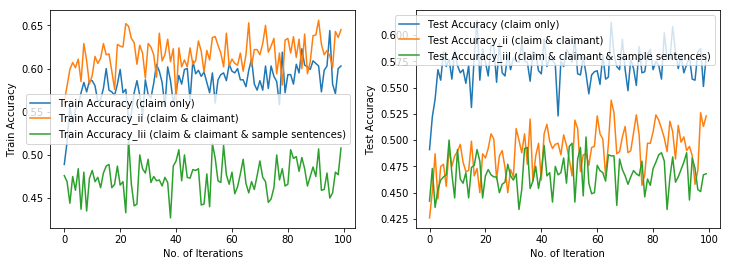

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(all_train_accuracies, label = 'Train Accuracy (claim only)')
plt.plot(all_train_accuracies_ii, label = 'Train Accuracy_ii (claim & claimant)')
plt.plot(all_train_accuracies_iii, label = 'Train Accuracy_Iii (claim & claimant & sample sentences)')
plt.xlabel('No. of Iterations')
plt.ylabel('Train Accuracy')

plt.legend()

plt.subplot(1,2,2)
plt.plot(all_test_accuracies, label = 'Test Accuracy (claim only)')
plt.plot(all_test_accuracies_ii, label = 'Test Accuracy_ii (claim & claimant)')
plt.plot(all_test_accuracies_iii, label = 'Test Accuracy_iiI (claim & claimant & sample sentences)')
plt.xlabel('No. of Iteration')
plt.ylabel('Test Accuracy')
plt.legend()

## Q2a) iii
### Changing the order of inputs (5 Sentences as the first input)

In [0]:
def train_iv(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn_iv.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn_iv(line_tensor[i], hidden)
    output = classifier_iv(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

Train: 1000  1% (0m 38s) average_accuracy=0.5170 average_loss=0.9688 Message from Starbucks Chairman Howard Schultz extols the company’s contributions to Israel. / 0 ✓
Test: 1000  1% (0m 38s) average_accuracy=0.4300 average_loss=0.9976 "All these cases have been branded ‘likes and reposts cases’ … We must draw the line here - we do have [criminal cases opened] for reposts, because reposts mean information is uploaded, but no criminal cases have been opened for ‘likes.’" / 1 ✓
Train: 2000  2% (1m 14s) average_accuracy=0.5770 average_loss=0.9275 New carbon regulations will increase electric bills by "$17 billion every year" and "potentially put an average of 224,000 more people out of work every year." / 1 ✗ (0)
Test: 2000  2% (1m 14s) average_accuracy=0.4780 average_loss=0.9589 "A miscarriage is considered an abortion." / 0 ✗ (1)
Train: 3000  3% (1m 50s) average_accuracy=0.5740 average_loss=0.9138 Bernie Sanders was omitted from the Chicago primary ballot.

				
					

						See Example

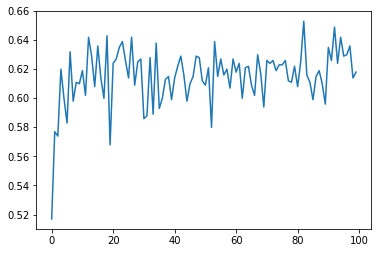

In [19]:
import time
import math

n_hidden = 128
n_categories = 3
rnn_iv = RNN(n_embedding_dims, n_hidden) #multiplied by 2 for claim+claimant
classifier_iv = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn_iv.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier_iv.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses = []
all_train_accuracies_iv = []
all_test_losses = []
all_test_accuracies_iv = []
count = 0
for iter in range(1, n_iters + 1):
    train_claim_tensor, train_category_tensor, train_claim, train_category, train_id = sampleClaim(train_data)
    train_claimant_tensor, train_claimant = sampleClaimant(train_id)
    
    train_sentences_tensor, train_sentences = sampleSentences(train_id)
    
    train_line_tensor = torch.cat((train_sentences_tensor, train_claim_tensor, train_claimant_tensor), 0)
    
     
    train_output, train_loss = train_iv(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_claim_tensor, test_category_tensor, test_claim, test_category, test_id = sampleClaim(test_data)
    test_claimant_tensor, test_claimant = sampleClaimant(test_id)
    test_sentences_tensor, test_sentences = sampleSentences(test_id)
    test_line_tensor = torch.cat(( test_sentences_tensor, test_claim_tensor, test_claimant_tensor), 0)
        
    test_output, test_loss = train_iv(test_category_tensor, test_line_tensor, update=False)
    
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_claim, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_claim, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies_iv.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies_iv.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_accuracies_iv)

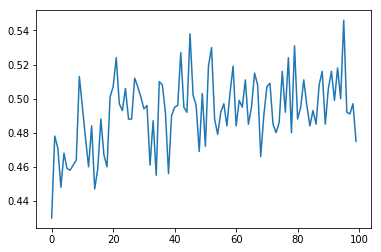

In [20]:
plt.plot(all__accuracies_iv)

### Final Result & Discussion

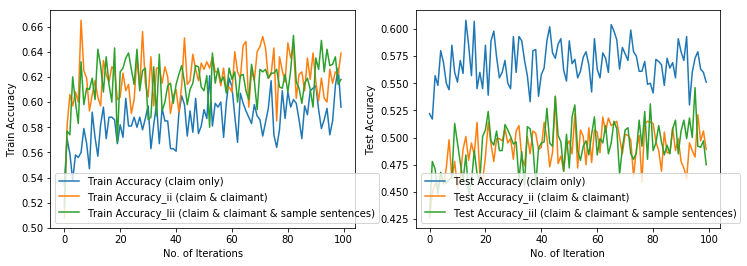

In [24]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(all_train_accuracies, label = 'Train Accuracy (claim only)')
plt.plot(all_train_accuracies_ii, label = 'Train Accuracy_ii (claim & claimant)')
plt.plot(all_train_accuracies_iv, label = 'Train Accuracy_Iii (claim & claimant & sample sentences)')
plt.xlabel('No. of Iterations')
plt.ylabel('Train Accuracy')

plt.legend()

plt.subplot(1,2,2)
plt.plot(all_test_accuracies, label = 'Test Accuracy (claim only)')
plt.plot(all_test_accuracies_ii, label = 'Test Accuracy_ii (claim & claimant)')
plt.plot(all_test_accuracies_iv, label = 'Test Accuracy_iiI (claim & claimant & sample sentences)')
plt.xlabel('No. of Iteration')
plt.ylabel('Test Accuracy')
plt.legend()

For training as the complexity of the input increases from claim only (i) to claim + claimant(ii) 
or claim + claimant + sample sentences (iii) the accuracy improves. However, the accuracy difference 
between models (ii) and (iii) is not noticable. My justification is that the RNN model is too simple and cannot take advantage of more detailed input information. However, if use GRU or LSTM units in our model the accuracy of the output will probably increse.

For test accuracy my models for (ii) and (iii) show overfitting. Their accuracies are almost the same. and the accuracy of claim only is more than the others. 